In [1]:
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
import tensorflow_datasets as tfds

print(tfds.__version__)

1.3.2


# Get dataset

In [3]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', 
                                                            split=list(splits),
                                                            with_info=True,
                                                            as_supervised=True)

In [4]:
print(metadata.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


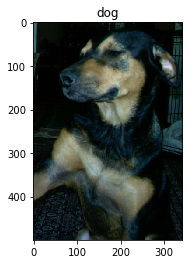

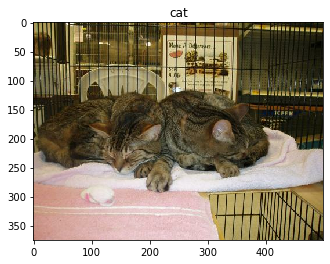

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

# Prepare input pipelines

In [6]:
IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [7]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
ds_train = raw_train.map(normalize_img)
ds_validation = raw_validation.map(normalize_img)
ds_test = raw_test.map(normalize_img)

In [9]:
ds_train = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_validation = ds_validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

# Get pretrained model

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
base_model.trainable = False

In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# (Optional): Use Tensorflow Hub

In [14]:
import tensorflow_hub as hub
print(hub.__version__)

0.8.0.dev


In [15]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_160/classification/4"
base_model = hub.KerasLayer(feature_extractor_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=False)

In [16]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1)
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1692489   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1002      
Total params: 1,693,491
Trainable params: 1,002
Non-trainable params: 1,692,489
_________________________________________________________________


# Compile model

In [18]:
base_learning_rate = 1e-4

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Evaluate random model

In [19]:
loss0, accuracy0 = model.evaluate(ds_validation)

     73/Unknown - 5s 72ms/step - loss: 1.1503 - accuracy: 0.4358

# Train model

In [20]:
initial_epochs = 3

history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_validation)

Epoch 1/3
582/582 [==============================] - 27s 46ms/step - loss: 0.5690 - accuracy: 0.7017 - val_loss: 0.4069 - val_accuracy: 0.8022
Epoch 2/3
582/582 [==============================] - 23s 40ms/step - loss: 0.3905 - accuracy: 0.8111 - val_loss: 0.3690 - val_accuracy: 0.8302
Epoch 3/3
582/582 [==============================] - 24s 41ms/step - loss: 0.3612 - accuracy: 0.8270 - val_loss: 0.3482 - val_accuracy: 0.8366


# Fine-tune

In [21]:
base_model.trainable = True

In [22]:
base_learning_rate = 1e-5

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1692489   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1002      
Total params: 1,693,491
Trainable params: 1,679,411
Non-trainable params: 14,080
_________________________________________________________________


In [24]:
fine_tune_epochs = 3
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_validation)

Epoch 3/6
582/582 [==============================] - 56s 95ms/step - loss: 0.3367 - accuracy: 0.8987 - val_loss: 0.2620 - val_accuracy: 0.9366
Epoch 4/6
582/582 [==============================] - 48s 82ms/step - loss: 0.2734 - accuracy: 0.9287 - val_loss: 0.2230 - val_accuracy: 0.9483
Epoch 5/6
582/582 [==============================] - 47s 81ms/step - loss: 0.2495 - accuracy: 0.9378 - val_loss: 0.2128 - val_accuracy: 0.9547
Epoch 6/6
582/582 [==============================] - 47s 81ms/step - loss: 0.2357 - accuracy: 0.9432 - val_loss: 0.2045 - val_accuracy: 0.9599
